<a href="https://colab.research.google.com/github/mcnica89/DATA6100_F23/blob/main/letter2vec_build_makemore_with_simple_vectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Purpose

Given a set of words, creates an embedding of letters (i.e. "letter2vec") which are vectors $v_a \in \mathbb{R}^{n_embedd}$ for each letter $a$ in the alphabet. The vectors $v_a$ are obtained by the following steps:
1. Create a dataset of pairs ($k$-th letter, $k+1$-st letter) from a given collection of words.
2. Given a set of vectors $v_a$, measure the ability of those vectors to correctly predict the training set by using the prescription that:

$$P(\ell_{k+1} = a|\ell_{k} = b) \propto \exp( \langle v_{a}, v_{b} \rangle)$$

3. Start with a random collection of vectors $v_a$, and then improve them by doing gradient descent on the cross entropy loss of these probabilities with respect to the dataset.

Based heavily on the wonderful series by Andrej Karpathy, see https://www.youtube.com/watch?v=PaCmpygFfXo and https://www.youtube.com/watch?v=TCH_1BHY58I

# Set up packages/dataset

In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
from tqdm import tqdm
%matplotlib inline

In [2]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-11-24 19:14:35--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.10’

names.txt.10        100%[===================>] 222.80K  --.-KB/s    in 0.1s    

2023-11-24 19:14:35 (1.74 MB/s) - ‘names.txt.10’ saved [228145/228145]



In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

# Create the dataset

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)} #stoi = "string to integer"
stoi['.'] = 0 #special string for start or end of a name!
itos = {i:s for s,i in stoi.items()} #itos = "integer to string"
print("indices to alphabet: ",itos)

alphabet_size = len(stoi)
print(f"{alphabet_size=}")

indices to alphabet:  {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
alphabet_size=27


In [6]:
# build the dataset
# the dataset consists of X,Y pairs where X=previous character, Y=next character

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = 0 #"context" stores the previous character
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = ix

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625]) torch.Size([182625])
torch.Size([22655]) torch.Size([22655])
torch.Size([22866]) torch.Size([22866])


# Setup the vectors

In [7]:
g = torch.Generator().manual_seed(1) # random number generator! for reproducibility

embedding_dim = 6 #size of the vectors!

v = torch.randn((27, embedding_dim), generator=g) #v[a] is the vector for letter a
parameters = [v]

for p in parameters:
  p.requires_grad = True



# Training

In [8]:
#bookkeeping for what happens during training!
lri = []
lossi = []
stepi = []

for i in tqdm(range(30000)):

  # minibatch construct
  minibatch_size = 256
  minibatch_ix = torch.randint(0, Xtr.shape[0], (minibatch_size,)) #randomly chosen indices for the minibatch

  # forward pass
  minibatch_X_emb = v[Xtr[minibatch_ix]] # embeddings of the inputs shape=(minibatch_size,embedding_dim)

  predicted_prob_logits = minibatch_X_emb @ v.T


  #h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  #logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(predicted_prob_logits, Ytr[minibatch_ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  lri.append(lr)
  stepi.append(i)
  lossi.append(loss.item())

print(loss.item())

100%|██████████| 30000/30000 [00:35<00:00, 845.55it/s]

2.8388051986694336


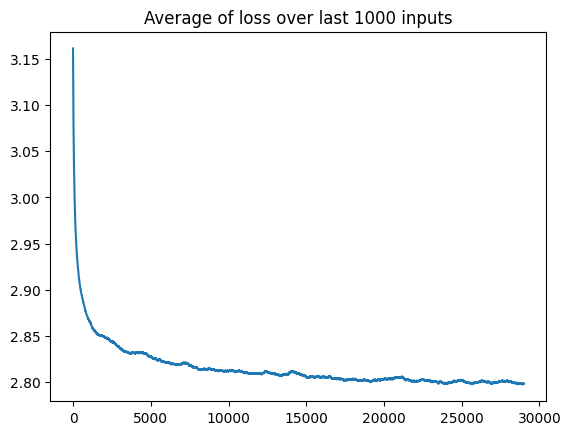

In [9]:
window_size = 1000
rolling_average = np.convolve(lossi, np.ones(window_size)/window_size, mode='valid')
plt.plot(rolling_average)
plt.title(f"Average of loss over last {window_size} inputs")
plt.show()

In [10]:
# training loss
def loss(myX,myY):
  emb = v[myX]
  logits = emb @ v.T
  return F.cross_entropy(logits, myY)

print(f"Training loss: {loss(Xtr,Ytr)}")
print(f"Dev loss: {loss(Xdev,Ydev)}")
print(f"Test loss: {loss(Xte,Yte)}")

Training loss: 2.7980847358703613
Dev loss: 2.7977516651153564
Test loss: 2.8022778034210205


# Visualize the result

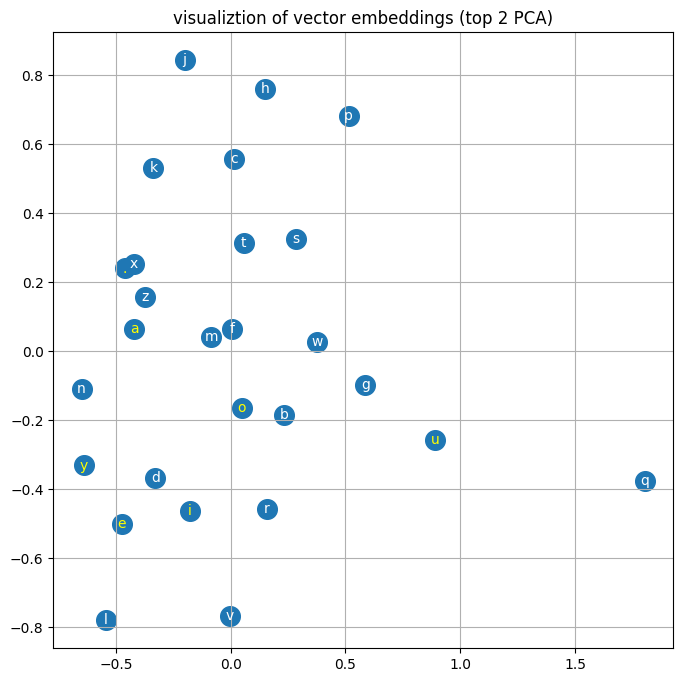

In [11]:
# visualize dimensions 0 and 1 of the embedding
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(v.detach().numpy())
my_v = pca.transform(v.detach().numpy())

plt.figure(figsize=(8,8))
plt.scatter(my_v[:,0].data,my_v[:,1].data, s=200)
plt.title("visualiztion of vector embeddings (top 2 PCA)")
for i in range(v.shape[0]):
    my_color = 'white'
    if itos[i] in ['a','e','i','o','u','.','y']:
      my_color = 'yellow'
    plt.text(my_v[i,0].item(), my_v[i,1].item(), itos[i], ha="center", va="center", color=my_color)
plt.grid('minor')

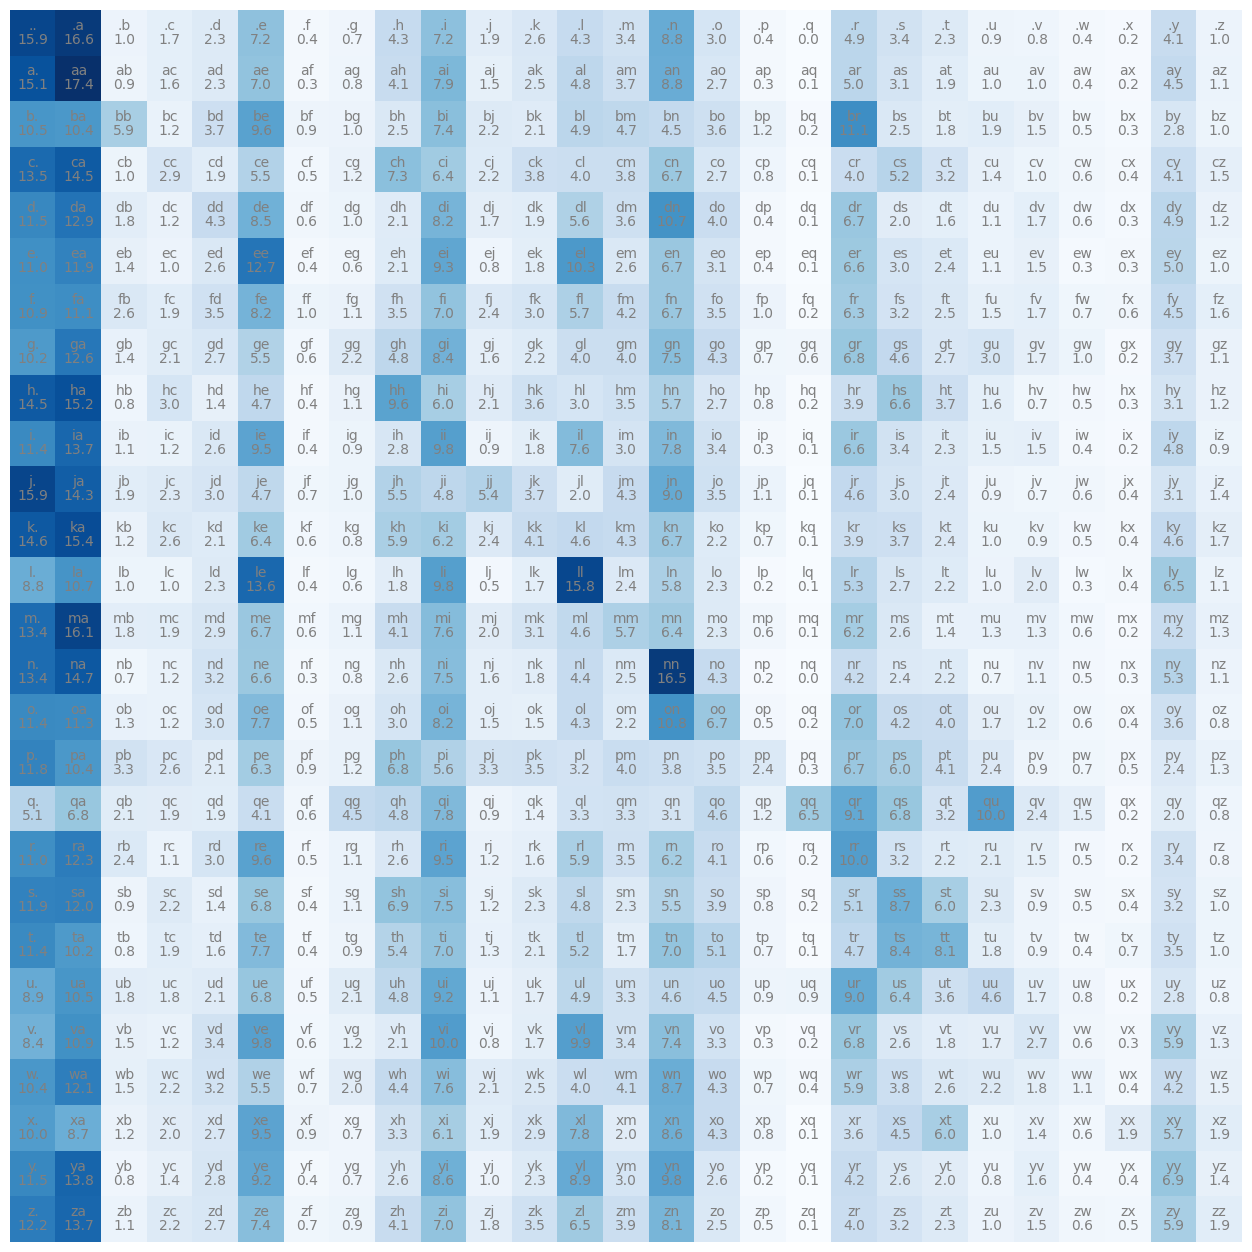

In [12]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

P = torch.exp(v @ v.T)
P = P / P.sum(axis=1,keepdim=True) #normalize so its probabilities
numpy_P = P.detach().numpy()

plt.figure(figsize=(16,16))
plt.imshow(numpy_P, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, round(100*numpy_P[i, j].item(),1), ha="center", va="top", color='gray')
plt.axis('off');

In [13]:
# sample from the model
g = torch.Generator().manual_seed(2 + 10)

for _ in range(20):

    out = []
    context = [0]
    while True:
      emb = v[context]
      logits = emb @ v.T
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

nnmhjoyiah.
neahr.
shkyrn.
d.
toeoeyldrgesk.
cyrip.
eaelt.
.
noayttashaimb.
elsxinkeykk.
ron.
auraakmrkyaej.
aliaeorozrshncengiuu.
mlkedojaairi.
amn.
shwnanlvy.
alyiiyijrelvrkalaoamr.
rdldaakxllnda.
en.
yymiallada.


# Letter2vec with TWO vector representations

This time we have a vector $v_a$ for each *input* letter and a different vector $w_b$ for each output vector, and we predict the probabilities are propotional to $\langle v_a , w_b \rangle$

# Setup the vectors

In [14]:
g = torch.Generator().manual_seed(1) # random number generator! for reproducibility

embedding_dim = 6 #size of the vectors!

v = torch.randn((27, embedding_dim), generator=g) #v[a] is the IN vector for letter a
w = torch.randn((27, embedding_dim), generator=g) #w[a] is the OUT vector for letter a


parameters = [v,w]

for p in parameters:
  p.requires_grad = True


In [15]:
#bookkeeping for what happens during training!
lri = []
lossi = []
stepi = []

for i in tqdm(range(30000)):

  # minibatch construct
  minibatch_size = 256
  minibatch_ix = torch.randint(0, Xtr.shape[0], (minibatch_size,)) #randomly chosen indices for the minibatch

  # forward pass
  minibatch_X_emb = v[Xtr[minibatch_ix]] # embeddings of the inputs shape=(minibatch_size,embedding_dim)

  predicted_prob_logits = minibatch_X_emb @ w.T


  #h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  #logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(predicted_prob_logits, Ytr[minibatch_ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  lri.append(lr)
  stepi.append(i)
  lossi.append(loss.item())

print(loss.item())

100%|██████████| 30000/30000 [00:40<00:00, 733.36it/s]

2.4494218826293945


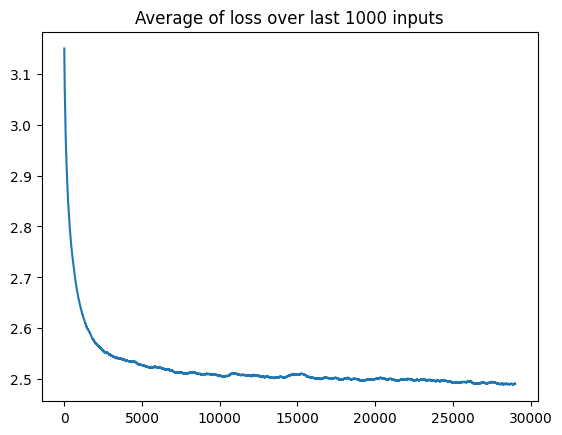

In [16]:
#plt.plot(stepi, lossi)
window_size = 1000
rolling_average = np.convolve(lossi, np.ones(window_size)/window_size, mode='valid')
plt.plot(rolling_average)
plt.title(f"Average of loss over last {window_size} inputs")
plt.show()

In [17]:
# training loss
def loss(myX,myY):
  emb = v[myX]
  logits = emb @ w.T
  return F.cross_entropy(logits, myY)

print(f"Training loss: {loss(Xtr,Ytr)}")
print(f"Dev loss: {loss(Xdev,Ydev)}")
print(f"Test loss: {loss(Xte,Yte)}")

Training loss: 2.491203546524048
Dev loss: 2.4891111850738525
Test loss: 2.4947962760925293


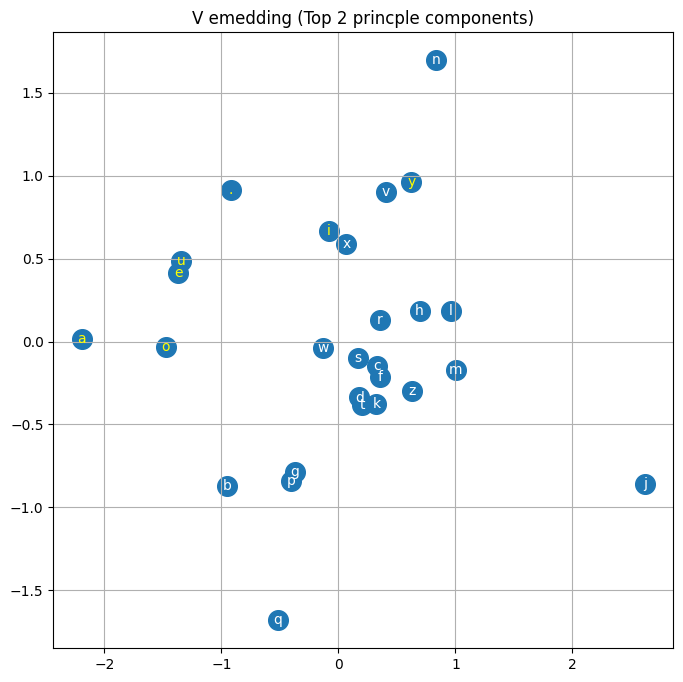

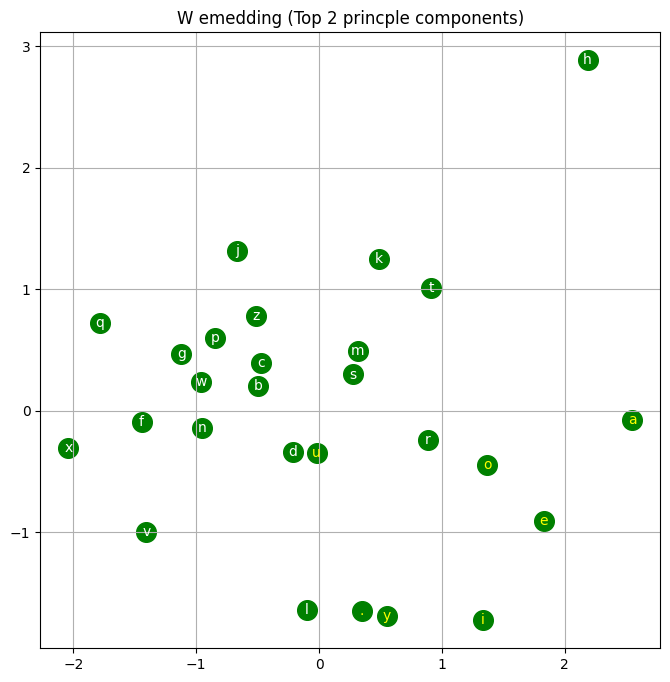

In [18]:
# visualize dimensions 0 and 1 of the embedding
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(v.detach().numpy())
my_v = pca.transform(v.detach().numpy())

plt.figure(figsize=(8,8))
plt.title("V emedding (Top 2 princple components)")
plt.scatter(my_v[:,0].data,my_v[:,1].data, s=200)
for i in range(v.shape[0]):
    my_color = 'white'
    if itos[i] in ['a','e','i','o','u','.','y']:
      my_color = 'yellow'
    plt.text(my_v[i,0].item(), my_v[i,1].item(), itos[i], ha="center", va="center", color=my_color)
plt.grid('minor')
plt.show()

plt.figure(figsize=(8,8))
plt.title("W emedding (Top 2 princple components)")
pca = PCA(n_components=2)
pca.fit(w.detach().numpy())
my_w = pca.transform(w.detach().numpy())

plt.scatter(my_w[:,0].data,my_w[:,1].data, s=200,color="g")
for i in range(v.shape[0]):
    my_color = 'white'
    if itos[i] in ['a','e','i','o','u','.','y']:
      my_color = 'yellow'
    plt.text(my_w[i,0].item(), my_w[i,1].item(), itos[i], ha="center", va="center", color=my_color)
plt.grid('minor')



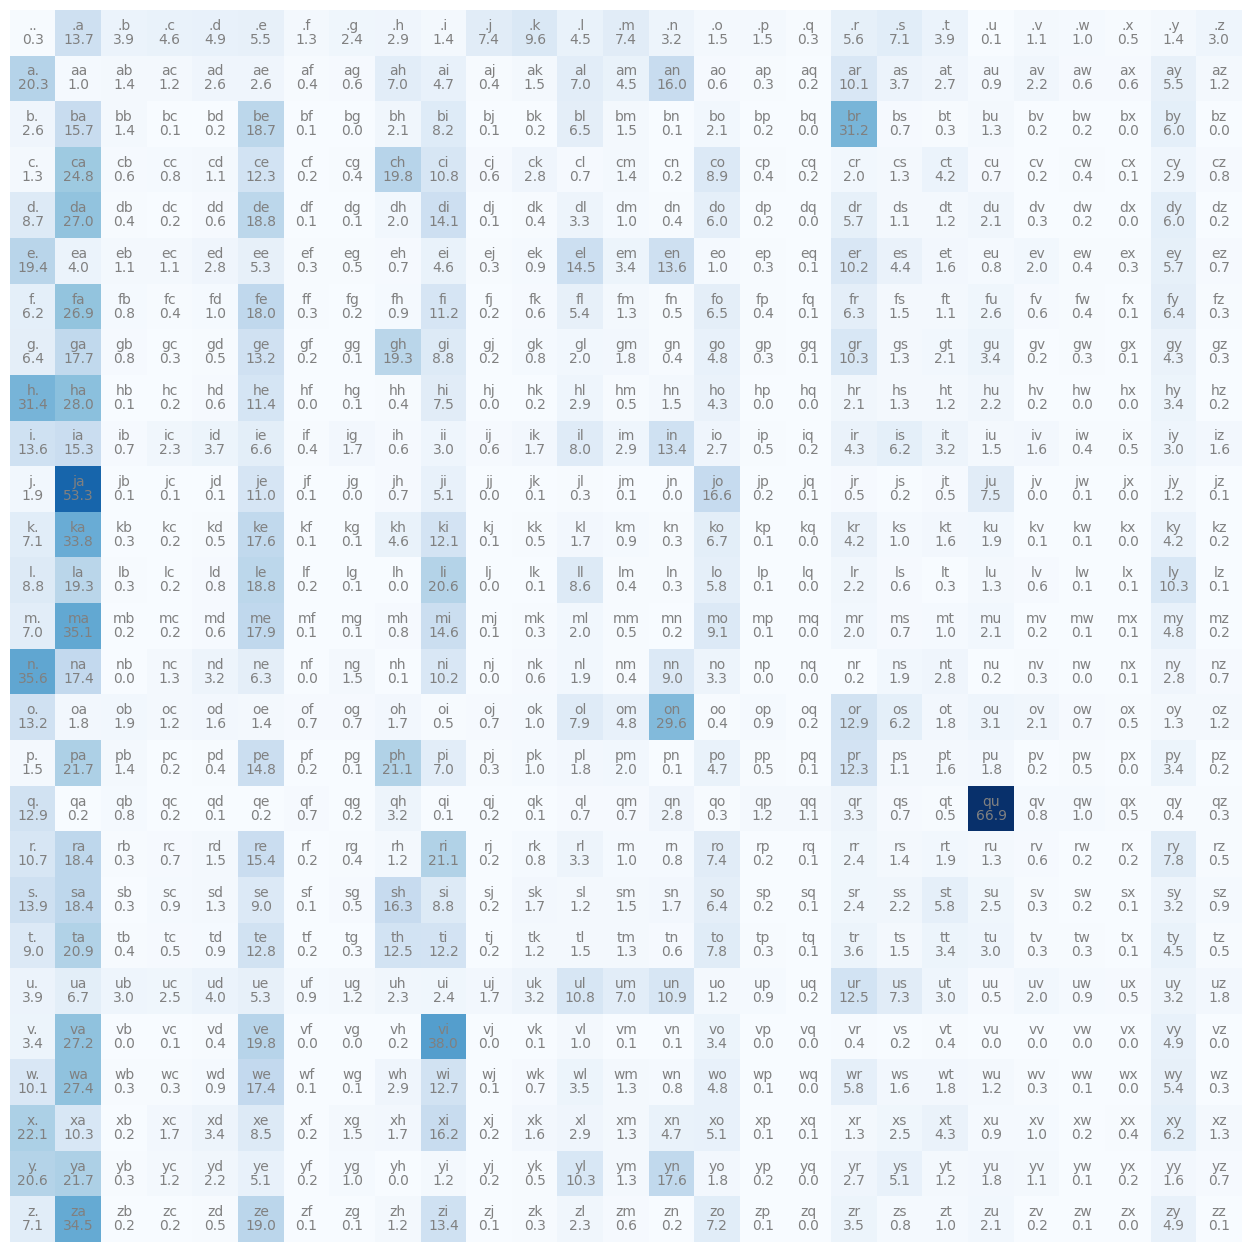

In [19]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

P = torch.exp(v @ w.T)
P = P / P.sum(axis=1,keepdim=True) #normalize so its probabilities
numpy_P = P.detach().numpy()

plt.figure(figsize=(16,16))
plt.imshow(numpy_P, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, round(100*numpy_P[i, j].item(),1), ha="center", va="top", color='gray')
plt.axis('off');

In [20]:
# sample from the model
g = torch.Generator().manual_seed(1)

for _ in range(50):

    out = []
    context = [0]
    while True:
      emb = v[context]
      logits = emb @ w.T
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

h.
jeres.
ena.
coge.
wicayayaranann.
linil.
rinilecavena.
ecatarylezr.
a.
valiruverleimee.
karo.
sdema.
ellalevenylan.
mi.
konabi.
e.
mion.
ch.
agmnveravithanahenn.
ynynade.
kakalylanondala.
bah.
dbh.
eranda.
vaeiondyllroseyaneviae.
jed.
prname.
ghahe.
ce.
tahyarenielyavidlyla.
kimetiana.
grijka.
giian.
sgha.
eeyaneraga.
kavemeyviatotva.
leryaieliapb.
rely.
kon.
rosnliyn.
erch.
ja.
hyndekhalsh.
jazerajavttsoca.
gyanavo.
re.
noleli.
lorctanemwawhetlan.
sg.
brle.
